<a href="https://colab.research.google.com/github/khiljaekang/colab/blob/main/Surface_Crack_Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

https://www.kaggle.com/arunrk7/surface-crack-detection

In [6]:
import os
os.environ['KAGGLE_USERNAME'] = 'kangkhiljae' # username
os.environ['KAGGLE_KEY'] = '073d45ae1951331f50f45182fa1fe63e' # key

In [7]:
!kaggle datasets download -d arunrk7/surface-crack-detection

 93% 217M/233M [00:08<00:00, 31.3MB/s]
100% 233M/233M [00:08<00:00, 28.7MB/s]


In [8]:
!unzip -q surface-crack-detection.zip

# Install alibi_detect

In [9]:
!pip install alibi_detect #Negative = normal / image Positive = crack image

     |████████████████████████████████| 153kB 9.9MB/s 
     |████████████████████████████████| 2.1MB 15.4MB/s 
     |████████████████████████████████| 3.3MB 42.0MB/s 
     |████████████████████████████████| 901kB 39.7MB/s 


# Import Packages

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
# from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

# Load Normal Images

- Negative: normal images
- Positive: crack images

In [12]:
img_list = glob('Negative/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2021)

def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(train_img_list[:1000])
x_train = x_train.astype(np.float32) / 255.

x_val = img_to_np(val_img_list[:1000])
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(1000, 64, 64, 3)
(1000, 64, 64, 3)


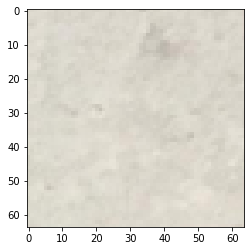

In [13]:
plt.imshow(x_train[100])

# Build Model

In [16]:
latent_dim = 1024

encoder_net = tf.keras.Sequential([  #인코더로 차원을 줄여줌
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([ #디코더로 늘려줌
    InputLayer(input_shape=(latent_dim,)), #디코더의 인풋은 latent_dim
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)), #reshape을 3d형태로 해줌
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid') # 64 x 64 x 3 짜리 인풋이미지와 같은 사이즈가 나옴, 0~1 사이의 값(sigmoid)
])

od = OutlierVAE(   
    threshold=.005, #instance score 인풋 이미지와 재생성 이미지의 픽셀 차이 점수 instance_score < 0.005 ->정상 // instance_score > 0.005 -> 비정상
    score_type='mse', 
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

# Train

In [17]:
od.fit(
    x_train,
    epochs=30,
    verbose=True
)

16/16 [=] - 2s 108ms/step - loss: -22116.8990


# Reconstruct Training Image

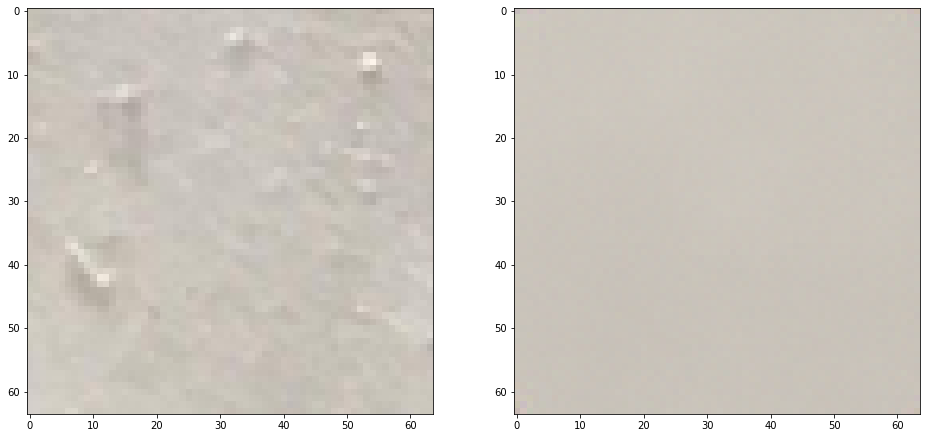

In [18]:
idx = 7
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

# Validation

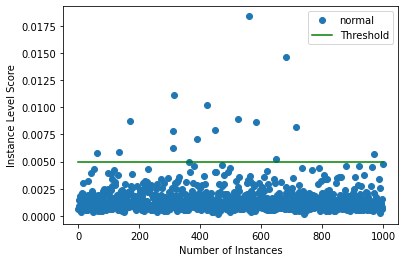

In [19]:
od_preds = od.predict(
    x_val,
    outlier_type='instance', #픽셀의 값을 뺀 것을 사용 , 픽셀의 차이가 크지 않다 = 정상인 이미지 
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# Reconstruct Validation Images

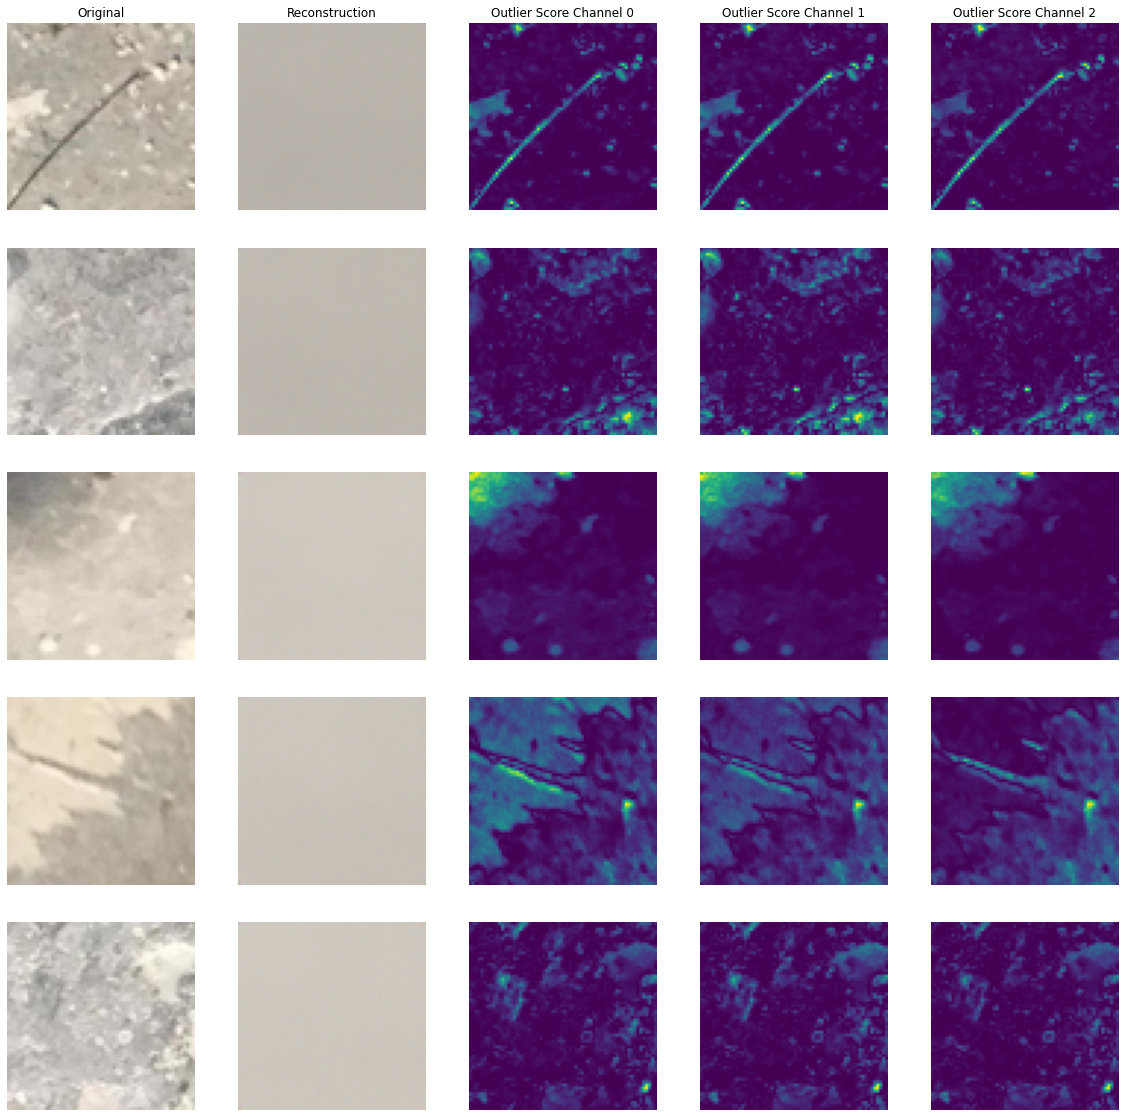

In [21]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image( 
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False # False는 모든 이미지, True는 0.05 위에 있는 이미지만 
)

# Outliers

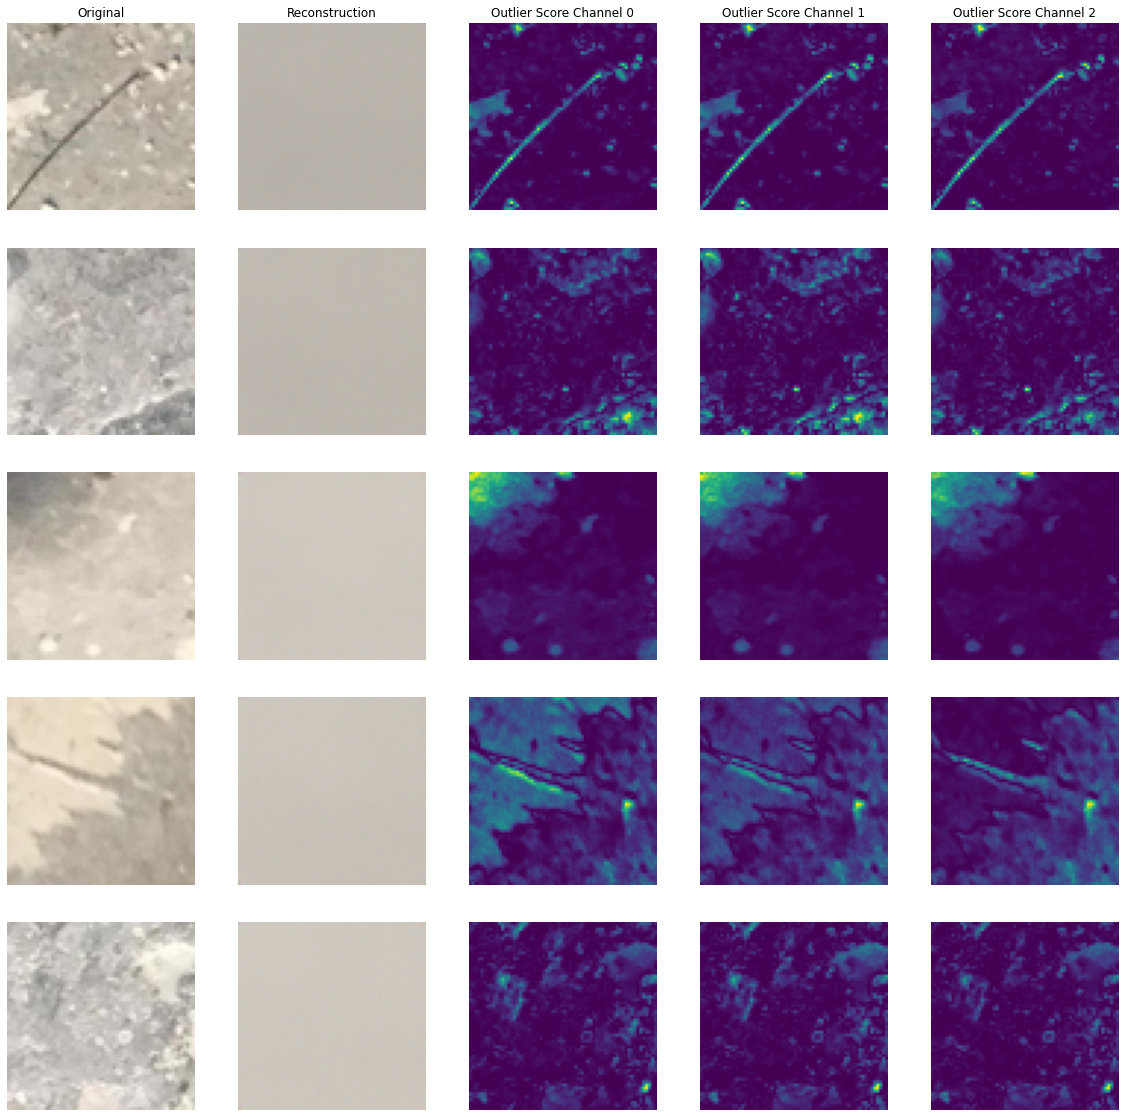

In [22]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

# Test with Crack Images

In [23]:
test_img_list = glob('Positive/*.jpg')

x_test = img_to_np(test_img_list[:32])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(32, 64, 64, 3)


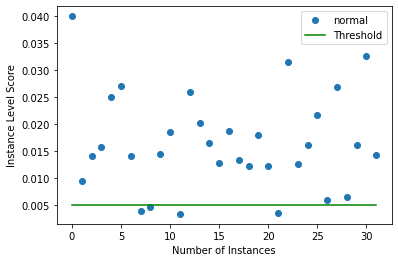

In [25]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

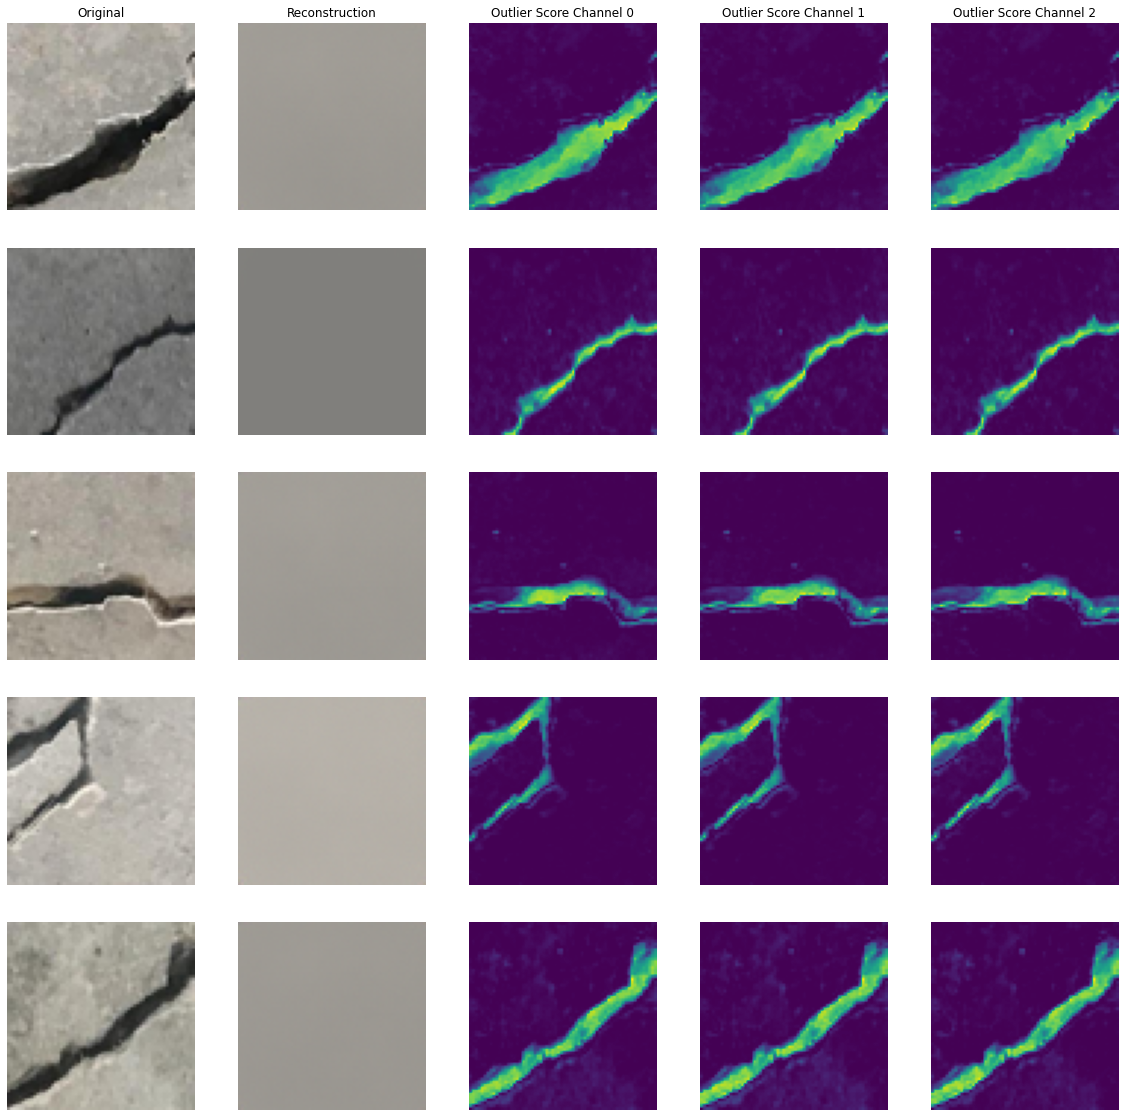

In [27]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)